## 膜电压计算

$$V(t)=\sum_{i}^{}w_{i} \sum_{t_{i}}^{}K(t-t_{i})+V_{rest}　\tag{1}$$

##  $t_{max}$
$$t_{max} =\frac{ (\tau  * \tau_{s} * log(\frac{\tau}{\tau_{s}}  ))}{ (\tau - \tau_{s})} \tag{2}$$

$$V(t) =\sum_{i}^{}w_{i}\sum_{t_{i}}^{}V_{0}(\exp[-(t-t_{i})/\tau ] - \exp [-(t-t_{i})/\tau_{s}] ) \tag{2.1}$$
$$\frac{dV}{dt} =\sum_{i}^{}w_{i} \sum V_{0}(\exp[-(t-t_{i})/\tau *(-\frac{1}{\tau} )]-\exp [-(t-t_{i})/\tau _{s}*(-\frac{1}{\tau_{s}} )] ) $$
$t_{max}$的值就是导数为0的时刻, $\frac{dV}{dt} =0$
$$\frac{\tau}{\tau_{s}}=e ^{\frac{t_{i}-t}{\tau } }  -e^\frac{{t_{i}-t} }{\tau_{s}} $$
$$log^{\frac{\tau}{\tau_{s}} }=\frac{t_{i}-t}{\tau} -\frac{t_{i}-t}{\tau_{s}}  $$
$$  t_{max}=\frac{ (\tau  * \tau_{s} * log(\frac{\tau}{\tau_{s}}  ))}{ (\tau - \tau_{s})} $$

In [31]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid.inset_locator import inset_axes

warnings.filterwarnings("ignore")
%matplotlib inline

In [32]:
class Tempotron:
    
    """
    The (subthreshold) membrane voltage of the tempotron
    is a weighted sum from all incoming spikes and the
    resting potential of the neuron. The contribution of
    each spike decays exponentiall with time, the speed of
    this decay is determined by two parameters tau and tau_s,
    denoting the decay time constants of membrane integration
    and synaptic currents, respectively.
    """

    def __init__(self, V_rest, tau, tau_s, synaptic_efficacies, threshold=1.0):
        # set parameters as attributes
        self.V_rest = V_rest
        self.tau = float(tau)
        self.tau_s = float(tau_s)
        self.log_tts = np.log(self.tau / self.tau_s)
        self.threshold = threshold
        self.efficacies = synaptic_efficacies
        # compute normalisation factor V_0
        self.V_norm = self.compute_norm_factor(tau, tau_s)

    def compute_norm_factor(self, tau, tau_s):
        """
        Compute and return the normalisation factor:
        V_0 = (tau * tau_s * log(tau/tau_s)) / (tau - tau_s)
        That normalises the function:

        K(t-t_i) = V_0 (exp(-(t-t_i)/tau) - exp(-(t-t_i)/tau_s)
        Such that it amplitude is 1 and the unitary PSP
        amplitudes are given by the synaptic efficacies.
        """
        tmax = (tau * tau_s * np.log(tau / tau_s)) / (tau - tau_s)
        v_max = self.K(1, tmax, 0)
        V_0 = 1 / v_max
        return V_0

    def K(self, V_0, t, t_i):
        """
        Compute the function
        K(t-t_i) = V_0 (exp(-(t-t_i)/tau) - exp(-(t-t_i)/tau_s)
        """
        if t < t_i:
            value = 0
        else:
            value = V_0 * (np.exp(-(t - t_i) / self.tau) - np.exp(-(t - t_i) / self.tau_s))
        return value

    def compute_membrane_potential(self, t, spike_times):
        """
        Compute the membrane potential of the neuron given
        by the function:
        V(t) = sum_i w_i sum_{t_i} K(t-t_i) + V_rest
        Where w_i denote the synaptic efficacies and t_i denote
        ith afferent.

        :param spike_times: an array with at position i the spike times of
                            the ith afferent
        :type spike_times: numpy.ndarray
        """
        # create an array with the contributions of the
        # spikes for each synaps
        spike_contribs = self.compute_spike_contributions(t, spike_times)

        # multiply with the synaptic efficacies
        total_incoming = spike_contribs * self.efficacies

        # add sum and add V_rest to get membrane potential
        V = total_incoming.sum() + self.V_rest

        return V

    def compute_derivative(self, t, spike_times):
        """
        Compute the derivative of the membrane potential
        of the neuron at time t.
        This derivative is given by:
        V'(t) = V_0 sum_i w_i sum_{t_n} (exp(-(t-t_n)/tau_s)/tau_s - exp(-(t-t_n)/tau)/tau)
        for t_n < t
        """
        # sort spikes in chronological order
        spikes_chron = [(time, synapse) for synapse in range(len(spike_times)) for time in spike_times[synapse]]
        spikes_chron.sort()

        # Make a list of spike times and their corresponding weights
        spikes = [(s[0], self.efficacies[s[1]]) for s in spikes_chron]

        # At time t we want to incorporate all the spikes for which
        # t_spike < t
        sum_tau = np.array([spike[1] * np.exp(spike[0] / self.tau) for spike in spikes if spike[0] <= t]).sum()
        sum_tau_s = np.array([spike[1] * np.exp(spike[0] / self.tau_s) for spike in spikes if spike[0] <= t]).sum()

        factor_tau = np.exp(-t / self.tau) / self.tau
        factor_tau_s = np.exp(-t / self.tau_s) / self.tau_s

        deriv = self.V_norm * (factor_tau_s * sum_tau_s - factor_tau * sum_tau)

        return deriv

    def compute_spike_contributions(self, t, spike_times):
        """
        Compute the decayed contribution of the incoming spikes.
        """
        # nr of synapses
        N_synapse = len(spike_times)
        # loop over spike times to compute the contributions
        # of individual spikes
        spike_contribs = np.zeros(N_synapse)
        for neuron_pos in range(N_synapse):
            for spike_time in spike_times[neuron_pos]:
                # print(self.K(self.V_rest, t, spike_time))
                # print(f"{t}------------------{spike_time}")
                spike_contribs[neuron_pos] += self.K(self.V_norm, t, spike_time)
        return spike_contribs

    def train(self, io_pairs, steps, learning_rate):
        """
        Train the tempotron on the given input-output pairs,
        applying gradient decscend to adapt the weights.
        :param steps: the maximum number of training steps
        :param io_pairs: a list with tuples of spike times and the
                         desired response on them
        :param learning_rate: the learning rate of the gradient descend
        """
        # Run until maximum number of steps is reached or
        # no weight updates occur anymore
        for i in range(steps):
            # go through io-pairs in random order
            for spike_times, target in np.random.permutation(io_pairs):
                # print(spike_times, target)
                self.loss_func(spike_times, target, learning_rate)
        return

    def get_membrane_potentials(self, t_start, t_end, spike_times, interval=0.1):
        """
        Get a list of membrane potentials from t_start to t_end
        as a result of the inputted spike times.
        """
        # create vectorised version of membrane potential function
        potential_vect = np.vectorize(self.compute_membrane_potential)
        # exclude spike times from being vectorised
        potential_vect.excluded.add(1)

        # compute membrane potentials
        t = np.arange(t_start, t_end, interval)
        membrane_potentials = potential_vect(t, spike_times)

        return t, membrane_potentials

    def get_derivatives(self, t_start, t_end, spike_times, interval=0.1):
        """
        Get a list of the derivative of the membrane potentials from
        t_start to t_end as a result of the inputted spike times.
        """
        # create a vectorised version of derivative function
        deriv_vect = np.vectorize(self.compute_derivative)
        # exclude spike times from being vectorised
        deriv_vect.excluded.add(1)

        # compute derivatives
        t = np.arange(t_start, t_end, interval)
        derivatives = deriv_vect(t, spike_times)

        return t, derivatives

    def plot_potential_and_derivative(self, t_start, t_end, spike_times, interval=0.1):
        """
        Plot the membrane potential and the derivative of the membrane
        potential as a result of the input spikes between t_start and
        t_end.
        :param t_start: start time in ms
        :param t_end: end time in ms
        """
        # compute membrane potentials
        t, membrane_potentials = self.get_membrane_potentials(t_start, t_end, spike_times, interval)

        # compute derivatives
        t, derivatives = self.get_derivatives(t_start, t_end, spike_times, interval)

        # format axes
        plt.xlabel('Time(ms)')
        # ylabel???

        ymax = max(membrane_potentials.max() + 0.1, self.threshold + 0.1)
        ymin = min(membrane_potentials.min() - 0.1, -self.threshold - 0.1)
        plt.ylim(ymax=ymax, ymin=ymin)

        plt.axhline(y=self.threshold, linestyle='--', color='k')
        plt.axhline(y=0.0, linestyle='--', color='r')
        plt.axvline(x=16.5, color='b')

        # plot
        plt.plot(t, membrane_potentials, label='Membrane potential')
        plt.plot(t, derivatives, label='Derivative')
        plt.show()

    def compute_tmax(self, spike_times):
        """
        Compute the maximum mebrane potential of the tempotron as
        a result of the input spikes.
        The maxima of the function can be computed analytically, but as
        there are as many maxima and minima as their are number of spikes,
        we still need to sort through them to find the highest one.
        The maxima are given by:
        t = (log(tau/tau_s) + log(sum w_n exp(t_n/tau_s)) - log(sum w_n exp(t_n/tau)))*tau_s*tau/ (tau-tau_s)
        for n = 1, 2, ..., len(spike_times)
        The time at which the membrane potential is maximal is given by
        Check if the input spikes result produce the desired
        output. Return tmax. (maybe I should return something else)
        """

        # sort spikes in chronological order
        spikes_chron = [(time, synapse) for synapse in range(len(spike_times)) for time in spike_times[synapse]]
        spikes_chron.sort()

        # Make a list of spike times and their corresponding weights
        spikes = [(s[0], self.efficacies[s[1]]) for s in spikes_chron]
        times = np.array([spike[0] for spike in spikes])
        weights = np.array([spike[1] for spike in spikes])

        sum_tau = (weights * np.exp(times / self.tau)).cumsum()
        sum_tau_s = (weights * np.exp(times / self.tau_s)).cumsum()

        # when an inhibitive spike is generated when the membrane potential
        # is still growing, the derivative does not exist in the maximum
        # In such cases, thus when sum_tau/sum_tau_s is negative,
        # manually set tmax to the spike time of the second spike
        div = sum_tau_s / sum_tau
        boundary_cases = div < 0
        div[boundary_cases] = 10

        tmax_list = self.tau * self.tau_s * (self.log_tts + np.log(div)) / (self.tau - self.tau_s)
        tmax_list[boundary_cases] = times[boundary_cases]

        vmax_list = np.array([self.compute_membrane_potential(t, spike_times) for t in tmax_list])

        tmax = tmax_list[vmax_list.argmax()]

        return tmax

    def loss_func(self, spike_times, target, learning_rate):
        """
        Modify the synaptic efficacies such that the learns
        to classify the input pattern correctly.
        Whenever an error occurs, the following update is
        computed:
        dw = lambda sum_{ti} K(t_max, ti)
        The synaptic efficacies are increased by this weight
        if the tempotron did erroneously not elecit an output
        spike, and decreased if it erroneously did.
        :param spike_times: an array with lists of spike times
                            for every afferent
        :param output_spike: the classification of the input pattern
        :type output_spike: Boolean
        """

        # compute tmax
        tmax = self.compute_tmax(spike_times)
        vmax = self.compute_membrane_potential(tmax, spike_times)

        # if target output is correct, don't adapt weights
        if (vmax >= self.threshold) == target:
            # print "no weight update necessary"
            return

        # compute weight updates
        dw = self.dw(learning_rate, tmax, spike_times)
        # print("update =", dw)

        if target is True:
            self.efficacies += dw
        else:
            self.efficacies -= dw

    def dw(self, learning_rate, tmax, spike_times):
        """
        Compute the update for synaptic efficacies wi,
        according to the following learning rule
        (implementing gradient descend dynamics):
        dwi = lambda sum_{ti} K(t_max, ti)
        where lambda is the learning rate and t_max denotes
        the time at which the postsynaptic potential V(t)
        reached its maximal value.
        """
        # compute the contributions of the individual spikes at
        # time tmax
        spike_contribs = self.compute_spike_contributions(tmax, spike_times)

        # multiply with learning rate to get updates
        update = learning_rate * spike_contribs

        return update
    

In [46]:
# 输出训练权重变化信息
np.random.seed(0)
efficacies = 1.8 * np.random.random(10) - 0.50
print(f'初始synaptic efficacies参数:\n {efficacies}\n')

tempotron = Tempotron(0, 10, 2.5, efficacies)
threshold = tempotron.threshold
spike_times1 = np.array([[70, 200, 400], [], [400, 420], [], [110], [230], [240, 260, 340], [380], [300], [105]])
spike_times2 = np.array([[], [395], [50, 170], [], [70, 280], [], [290], [115], [250, 320], [225, 330]])

t, ori_membrane_potentials = tempotron.get_membrane_potentials(0, 500, spike_times1)

tempotron.train([(spike_times1, True), (spike_times2, False)], 300, learning_rate=0.1)
print(f'训练好的synaptic efficacies参数权重:\n {tempotron.efficacies}')
_, membrane_potentials = tempotron.get_membrane_potentials(0, 500, spike_times1)

初始synaptic efficacies参数:
 [0.48786431 0.78734086 0.58497408 0.48078973 0.26257864 0.6626094
 0.28765698 1.1051914  1.23459297 0.19019473]

训练好的synaptic efficacies参数权重:
 [0.48786431 0.78734086 0.58457257 0.48078973 0.252244   0.6626094
 0.26762721 0.90519196 0.93424644 0.19016462]


(<matplotlib.patches.Rectangle at 0x7f6ecbad45f8>,
 (<matplotlib.patches.ConnectionPatch at 0x7f6ecbad4c50>,
  <matplotlib.patches.ConnectionPatch at 0x7f6ecbae0320>))

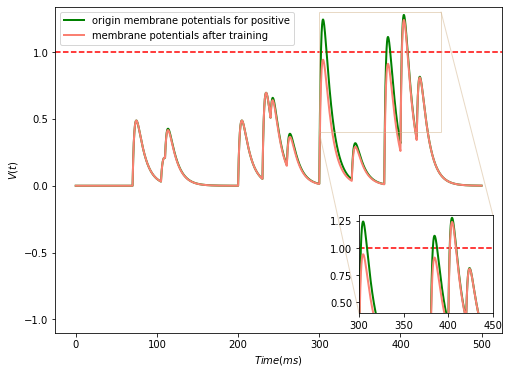

In [49]:
#plot正样本的膜电压变化曲线
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ymax = max(membrane_potentials.max() + 0.1, threshold + 0.1)
ymin = min(membrane_potentials.min() - 0.1, -threshold - 0.1)
plt.ylim(ymax=ymax, ymin=ymin)
plt.axhline(y=threshold, linestyle='--', color='r')
ax.plot(t, ori_membrane_potentials, color='green', linewidth=2.0, label='origin membrane potentials for positive')
ax.plot(t, membrane_potentials, color='salmon', linewidth=2.0, label='membrane potentials after training')
plt.xlabel('$Time (ms)$')
plt.ylabel('$V(t)$')
plt.legend(loc='best')

axins = ax.inset_axes((0.68, 0.06, 0.3, 0.3))
axins.axhline(y=threshold, linestyle='--', color='r')
axins.plot(t, ori_membrane_potentials, color='green', linewidth=2.0)
axins.plot(t, membrane_potentials, color='salmon', linewidth=2.0)
# the parameter contain x and y range
axins.axis([300, 450, 0.4, 1.3])  
ax.indicate_inset_zoom(axins, edgecolor="tan")


从上图可以发现,对于正样本训练之前的膜电压,分别在300、380和400ms激发产生了脉冲(激发了3次),对于正样本来说,我们希望神经元激发产生脉冲**<font color=red>有且仅1个** </font>。基于tempotorn算法使用梯度下降进行权重训练,我们从图中清晰的发现神经元的膜电压仅仅在400ms超过了阈值,也即是仅在400ms产生了一个脉冲。

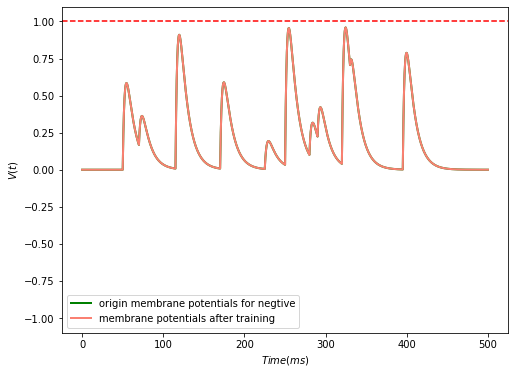

In [52]:
t, ori_membrane_potentials = tempotron.get_membrane_potentials(0, 500, spike_times2)
_, membrane_potentials = tempotron.get_membrane_potentials(0, 500, spike_times2)
#plot负样本的膜电压变化曲线
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ymax = max(membrane_potentials.max() + 0.1, threshold + 0.1)
ymin = min(membrane_potentials.min() - 0.1, -threshold - 0.1)
plt.ylim(ymax=ymax, ymin=ymin)
plt.axhline(y=threshold, linestyle='--', color='r')
ax.plot(t, ori_membrane_potentials, color='green', linewidth=2.0, label='origin membrane potentials for negtive')
ax.plot(t, membrane_potentials, color='salmon', linewidth=2.0, label='membrane potentials after training')
plt.xlabel('$Time (ms)$')
plt.ylabel('$V(t)$')
plt.legend(loc='best')


从上图可以发现,负样本在整个时间内都未发放脉冲(脉冲被抑制)。
**利用Tempotron学习规则进行简单的二分类训练，可以看到输出膜电位的变化。绿色为训练前的膜电位曲线，黄色为训练后的膜电位曲线。可见，训练后的Positive类别仍然发放脉冲，而训练后的Negative类别样本被抑制发放脉冲。**